<a href="https://colab.research.google.com/github/yohanes-erwin/notebook/blob/main/rnn_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks


### Data Preprocessing

Load data dari file .csv.

In [3]:
humidity = pd.read_csv("humidity.csv")
temp = pd.read_csv("temperature.csv")
pressure = pd.read_csv("pressure.csv")

In [4]:
humidity_SF = humidity[['datetime','San Francisco']]
temp_SF = temp[['datetime','San Francisco']]
pressure_SF = pressure[['datetime','San Francisco']]

In [5]:
humidity_SF.head(10)

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,88.0
2,2012-10-01 14:00:00,87.0
3,2012-10-01 15:00:00,86.0
4,2012-10-01 16:00:00,85.0
5,2012-10-01 17:00:00,84.0
6,2012-10-01 18:00:00,83.0
7,2012-10-01 19:00:00,82.0
8,2012-10-01 20:00:00,81.0
9,2012-10-01 21:00:00,80.0


In [6]:
humidity_SF.tail(10)

,datetime,San Francisco
45243,2017-11-29 15:00:00,NaN
45244,2017-11-29 16:00:00,NaN
45245,2017-11-29 17:00:00,NaN
45246,2017-11-29 18:00:00,NaN
45247,2017-11-29 19:00:00,NaN
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN
45252,2017-11-30 00:00:00,NaN


In [7]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45253, 2)
(45253, 2)
(45253, 2)


In [8]:
def plot_train_points(quantity='humidity', Tp=7000):
  plt.figure(figsize=(15,4))
  if quantity=='humidity':
    plt.title("Humidity of first {} data points".format(Tp), fontsize=16)
    plt.plot(humidity_SF['San Francisco'][:Tp], c='k', lw=1)
  if quantity=='temperature':
    plt.title("Temperature of first {} data points".format(Tp), fontsize=16)
    plt.plot(temp_SF['San Francisco'][:Tp], c='k', lw=1)
  if quantity=='pressure':
    plt.title("Pressure of first {} data points".format(Tp), fontsize=16)
    plt.plot(pressure_SF['San Francisco'][:Tp], c='k', lw=1)
  plt.grid(True)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()

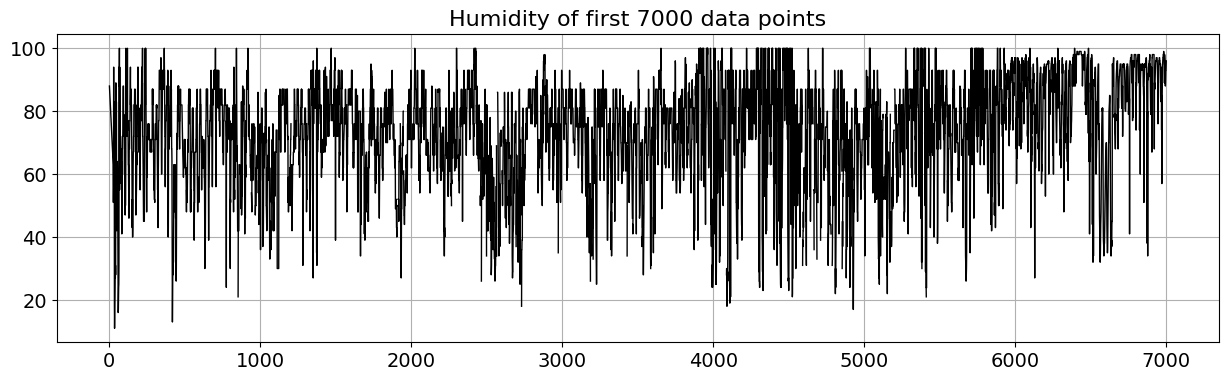

In [9]:
plot_train_points('humidity')

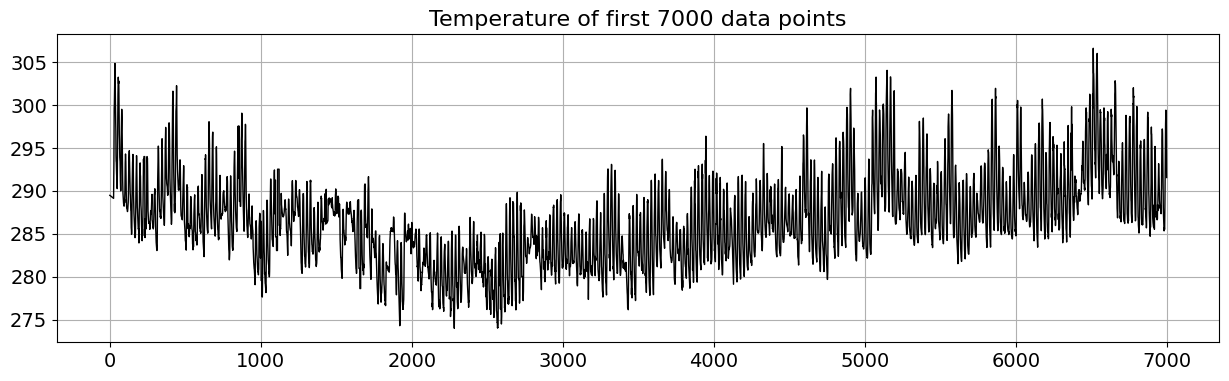

In [10]:
plot_train_points('temperature')

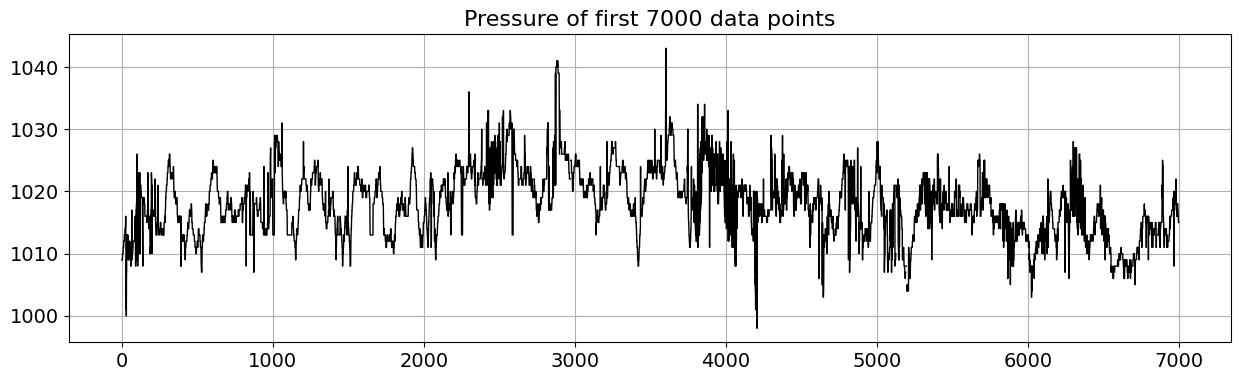

In [11]:
plot_train_points('pressure')

Melakukan interpolasi untuk data `NaN`.

In [12]:
print("How many NaN are there in the humidity dataset?", humidity_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the temperature dataset?", temp_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the pressure dataset?", pressure_SF.isna().sum()['San Francisco'])

How many NaN are there in the humidity dataset? 942
How many NaN are there in the temperature dataset? 793
How many NaN are there in the pressure dataset? 815


In [13]:
humidity_SF.interpolate(inplace=True)
humidity_SF.dropna(inplace=True)

temp_SF.interpolate(inplace=True)
temp_SF.dropna(inplace=True)

pressure_SF.interpolate(inplace=True)
pressure_SF.dropna(inplace=True)

In [14]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45252, 2)
(45252, 2)
(45252, 2)


In [15]:
print("How many NaN are there in the humidity dataset?", humidity_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the temperature dataset?", temp_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the pressure dataset?", pressure_SF.isna().sum()['San Francisco'])

How many NaN are there in the humidity dataset? 0
How many NaN are there in the temperature dataset? 0
How many NaN are there in the pressure dataset? 0


Membagi data menjadi data training dan test.

In [16]:
# Sample point untuk membagi data train dan test
Tp = 7000

In [17]:
train = np.array(humidity_SF['San Francisco'][:Tp])
test = np.array(humidity_SF['San Francisco'][Tp:])

In [18]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7000,)
Test data length: (38252,)


In [19]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [20]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7000, 1)
Test data length: (38252, 1)


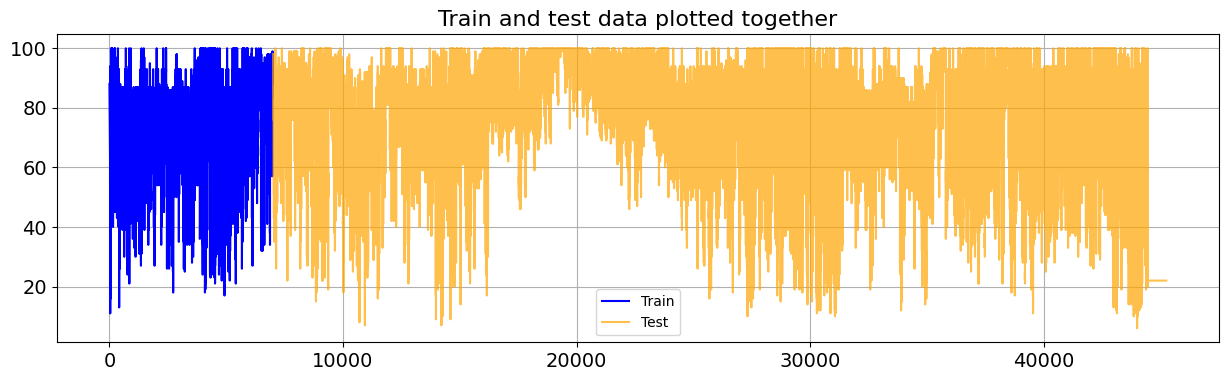

In [21]:
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together", fontsize=16)
plt.plot(np.arange(Tp), train, c='blue')
plt.plot(np.arange(Tp, 45252), test, c='orange', alpha=0.7)
plt.legend(['Train','Test'])
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Mengubah bentuk data menjadi step/embedding.

In [22]:
step = 8

In [23]:
# Menambahkan elemen step ke data train dan test
train = np.append(train, np.repeat(train[-1,], step))
test = np.append(test, np.repeat(test[-1,], step))

In [24]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7008,)
Test data length: (38260,)


In [25]:
def convertToMatrix(data, step):
  X, Y = [], []
  for i in range(len(data)-step):
    d = i + step
    X.append(data[i:d,])
    Y.append(data[d,])
  return np.array(X), np.array(Y)

In [26]:
trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)

In [27]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [28]:
print("Training data shape:", trainX.shape, ', ', trainY.shape)
print("Test data shape:", testX.shape, ', ', testY.shape)

Training data shape: (7000, 1, 8) ,  (7000,)
Test data shape: (38252, 1, 8) ,  (38252,)


### Recurrent Neural Network

Membuat model RNN.

In [29]:
num_units = 128
embedding = 8
num_dense = 32
lr = 0.0005

In [30]:
model = tf.keras.models.Sequential()

In [31]:
model.add(tf.keras.layers.SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
model.add(tf.keras.layers.Dense(num_dense, activation="relu"))
model.add(tf.keras.layers.Dense(1))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               17536     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,697
Trainable params: 21,697
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=['mse'])

In [34]:
# Callback function training
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if (epoch+1)%50 == 0 and epoch > 0:
      print("Epoch number {} done".format(epoch+1))

In [35]:
batch_size = 8
num_epochs = 1000

In [36]:
# Training model
model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, callbacks=[MyCallback()], verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


Plot loss dari hasil training.

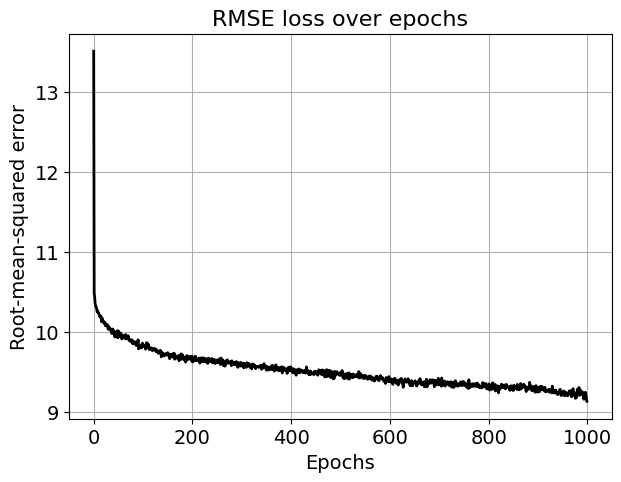

In [37]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs", fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']), c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Root-mean-squared error", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Inference

Melakukan prediksi dengan model yang sudah di-training.

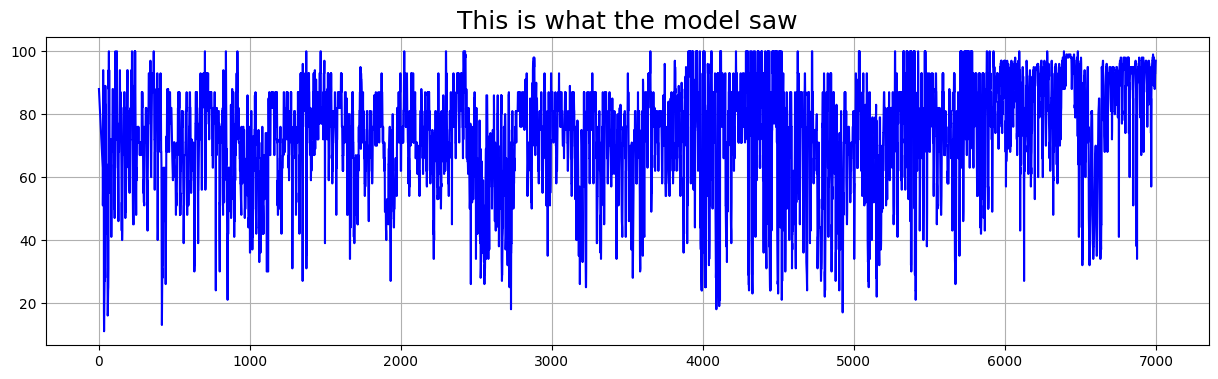

In [38]:
plt.figure(figsize=(15,4))
plt.title("This is what the model saw", fontsize=18)
plt.plot(trainX[:,0][:,0], c='blue')
plt.grid(True)
plt.show()

In [39]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict,testPredict), axis=0)

1196/1196 [==============================] - 2s 2ms/step


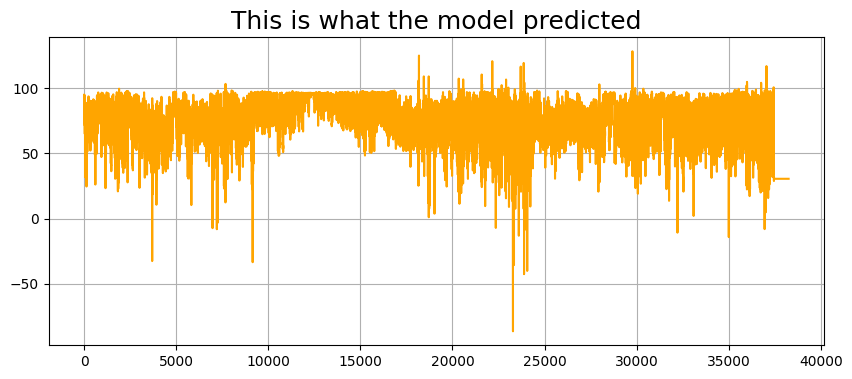

In [40]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted", fontsize=18)
plt.plot(testPredict, c='orange')
plt.grid(True)
plt.show()

Membandingkan dengan ground truth.

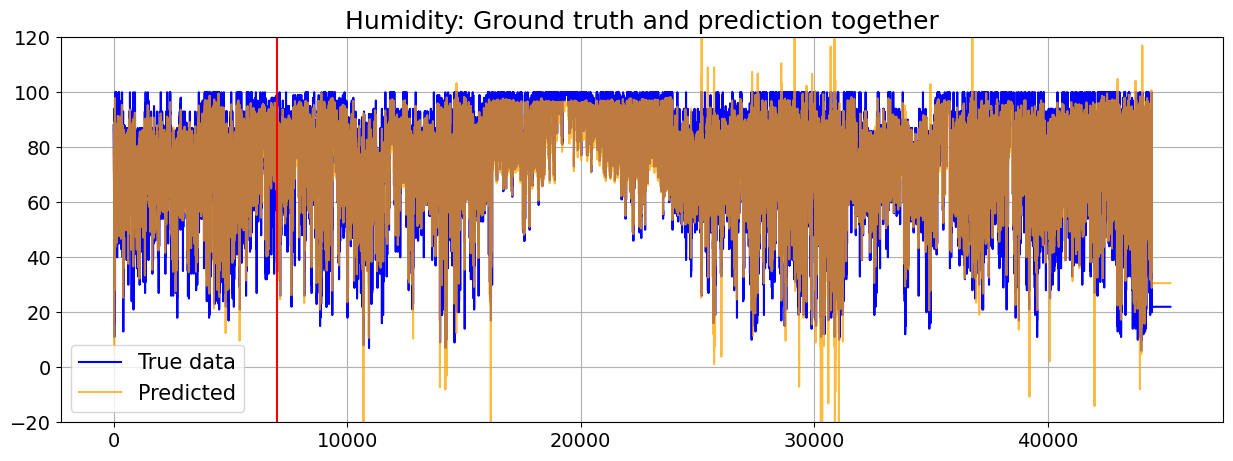

In [41]:
index = humidity_SF.index.values
plt.figure(figsize=(15,5))
plt.title("Humidity: Ground truth and prediction together", fontsize=18)
plt.plot(index, humidity_SF['San Francisco'], c='blue')
plt.plot(index, predicted, c='orange', alpha=0.75)
plt.legend(['True data','Predicted'], fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20,120)
plt.show()

### RNN Model for Temperature Data

Melakukan pemodelan RNN untuk data temperature.

In [42]:
train = np.array(temp_SF['San Francisco'][:Tp])
test = np.array(temp_SF['San Francisco'][Tp:])

train = train.reshape(-1,1)
test = test.reshape(-1,1)

step = 8

train = np.append(train, np.repeat(train[-1,], step))
test = np.append(test, np.repeat(test[-1,], step))

trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
num_units = 128
embedding = 8
num_dense = 32
lr = 0.0005

model_temp = tf.keras.models.Sequential()

model_temp.add(tf.keras.layers.SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
model_temp.add(tf.keras.layers.Dense(num_dense, activation="relu"))
model_temp.add(tf.keras.layers.Dense(1))

model_temp.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=['mse'])

batch_size = 8
num_epochs = 2000

model_temp.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, callbacks=[MyCallback()], verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done
Epoch number 1050 done
Epoch number 1100 done
Epoch number 1150 done
Epoch number 1200 done
Epoch number 1250 done
Epoch number 1300 done
Epoch number 1350 done
Epoch number 1400 done
Epoch number 1450 done
Epoch number 1500 done
Epoch number 1550 done
Epoch number 1600 done
Epoch number 1650 done
Epoch number 1700 done
Epoch number 1750 done
Epoch number 1800 done
Epoch number 1850 done
Epoch number 1900 done
Epoch number 1950 done
Epoch number 2000 done


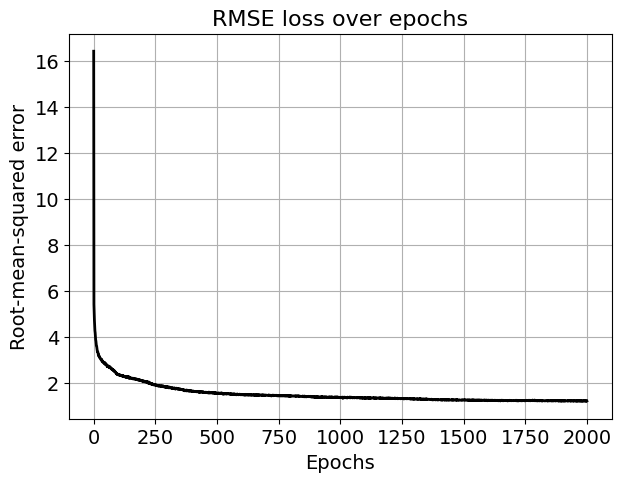

In [44]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs", fontsize=16)
plt.plot(np.sqrt(model_temp.history.history['loss']), c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Root-mean-squared error", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [45]:
trainPredict = model_temp.predict(trainX)
testPredict = model_temp.predict(testX)
predicted = np.concatenate((trainPredict,testPredict), axis=0)

1196/1196 [==============================] - 2s 2ms/step


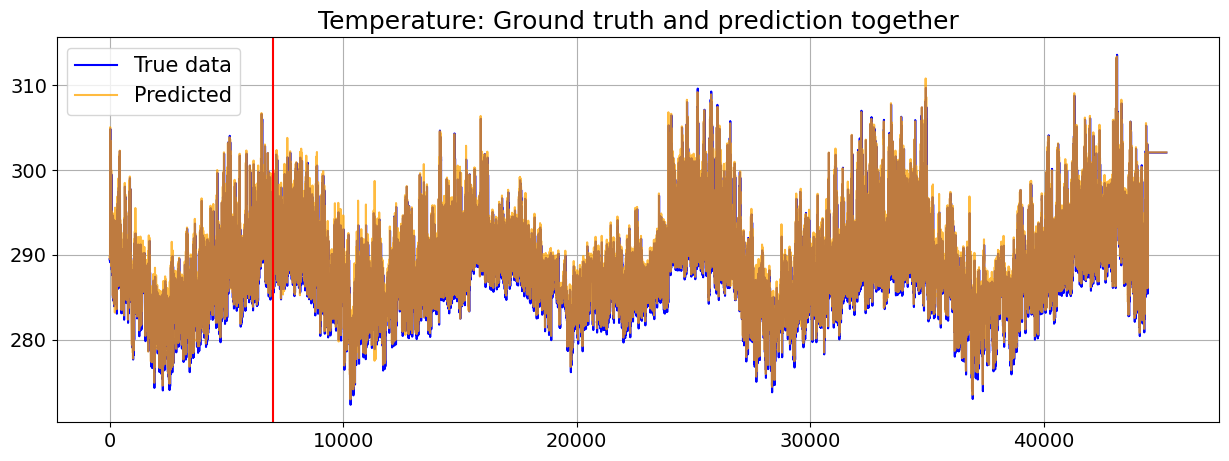

In [46]:
index = temp_SF.index.values
plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together", fontsize=18)
plt.plot(index, temp_SF['San Francisco'], c='blue')
plt.plot(index, predicted, c='orange', alpha=0.75)
plt.legend(['True data','Predicted'], fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### RNN Model for Pressure Data

Melakukan pemodelan RNN untuk data pressure.

In [47]:
train = np.array(pressure_SF['San Francisco'][:Tp])
test = np.array(pressure_SF['San Francisco'][Tp:])

train = train.reshape(-1,1)
test = test.reshape(-1,1)

step = 8

train = np.append(train, np.repeat(train[-1,], step))
test = np.append(test, np.repeat(test[-1,], step))

trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [48]:
num_units = 128
embedding = 8
num_dense = 32
lr = 0.0005

model_pressure = tf.keras.models.Sequential()

model_pressure.add(tf.keras.layers.SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
model_pressure.add(tf.keras.layers.Dense(num_dense, activation="relu"))
model_pressure.add(tf.keras.layers.Dense(1))

model_pressure.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=['mse'])

batch_size = 8
num_epochs = 500

model_pressure.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, callbacks=[MyCallback()], verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done


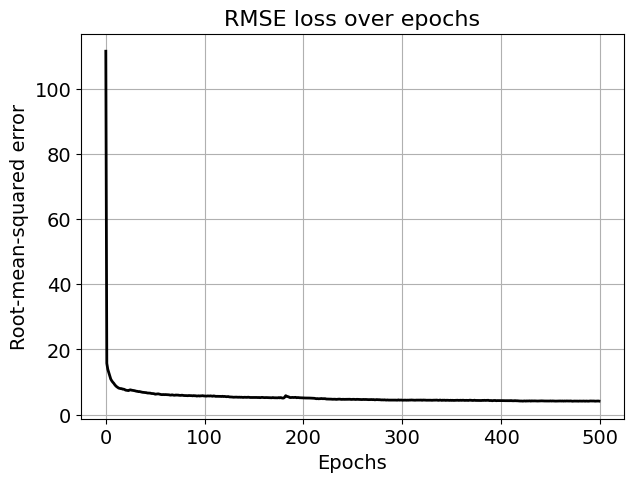

In [49]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs", fontsize=16)
plt.plot(np.sqrt(model_pressure.history.history['loss']), c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Root-mean-squared error", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [50]:
trainPredict = model_pressure.predict(trainX)
testPredict = model_pressure.predict(testX)
predicted = np.concatenate((trainPredict,testPredict), axis=0)

1196/1196 [==============================] - 2s 2ms/step


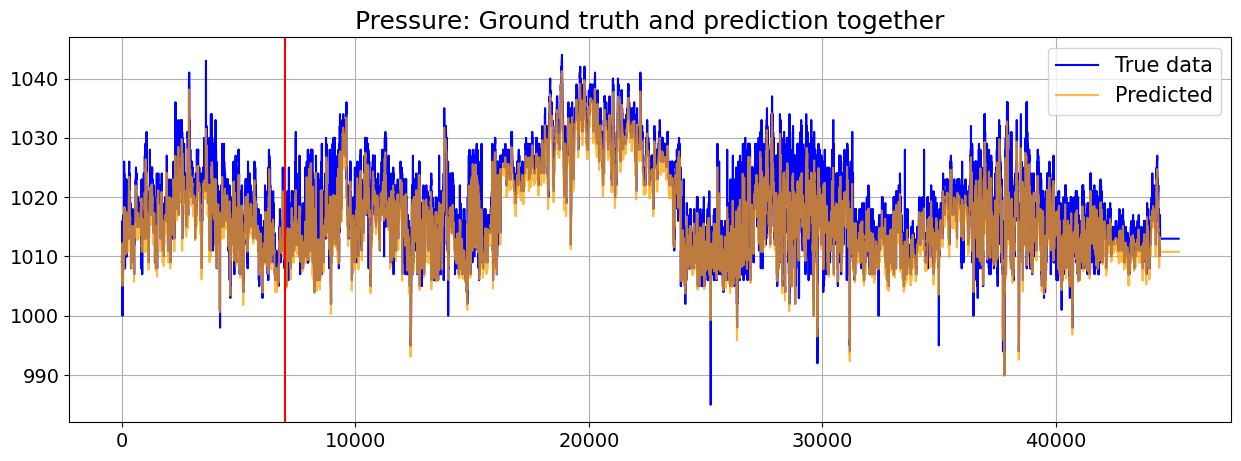

In [51]:
index = pressure_SF.index.values
plt.figure(figsize=(15,5))
plt.title("Pressure: Ground truth and prediction together", fontsize=18)
plt.plot(index, pressure_SF['San Francisco'], c='blue')
plt.plot(index, predicted, c='orange', alpha=0.75)
plt.legend(['True data','Predicted'], fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()